In [1]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

import torch
from torch import nn
from torchvision.datasets import FashionMNIST
from torchvision import transforms
from torch.utils.data import DataLoader, random_split

%matplotlib inline

In [2]:
rng = torch.Generator().manual_seed(42)

In [3]:
BATCH_SIZE = 128

# Helper functions

In [4]:
def plot_training(history: dict) -> None:
    """Plot the training losses.

    Args:
        history (dict): Dictionary ontaining test and validation loss for each epoch.
    """
    fig, ax = plt.subplots()
    ax.plot(history["epoch"], history["train_loss"], label="train_loss")
    ax.plot(history["epoch"], history["val_loss"], label="val_loss")

    ax.set_title("Training")
    ax.set_xlabel("Epoch")
    ax.set_ylabel("loss")    
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    
    ax.legend()
    plt.show()

# Download and prepare data

In [5]:
# Download train and test set
train = FashionMNIST("data", train=True, download=True, transform=transforms.ToTensor())
test = FashionMNIST("data", train=False, download=True, transform=transforms.ToTensor())

# Seperate validation set
train, val = random_split(train, [0.8, 0.2], generator=rng)

In [6]:
train_loader = DataLoader(train, BATCH_SIZE, shuffle=True, generator=rng)
val_loader = DataLoader(val, BATCH_SIZE)
test_loader = DataLoader(test, BATCH_SIZE)

In [7]:
class_names = [
    "T-shirt/top",
    "Trouser",
    "Pullover",
    "Dress",
    "Coat",
    "Sandal",
    "Shirt",
    "Sneaker",
    "Bag",
    "Ankle boot"
]

Pullover


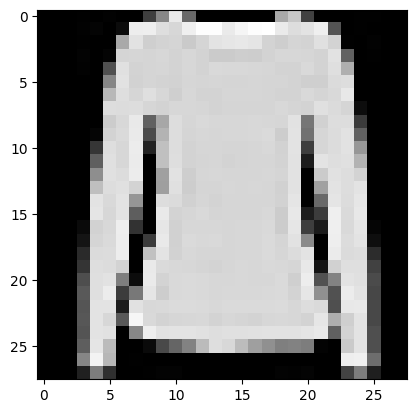

In [44]:
# Plot random observation and its class
idx = torch.randint(0, len(train_loader), (1, ))
X, y = train_loader.dataset[idx]
print(class_names[y])
plt.imshow(torch.squeeze(X, dim=0), cmap="gray");

# Multi Layer Perceptron

In [9]:
class MultiLayerPerceptron(nn.Module):
    """A fully-connected feedforward neural network with two hidden layer.
    """

    def __init__(self, hidden_dims: tuple[int, int]) -> None:
        """Initialize MLP.

        Args:
            hidden_dims (tuple[int, int]): Number of neurons for each hidden layer.
        """
        super().__init__()
        self.layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(28*28, hidden_dims[0]),
            nn.ReLU(),
            nn.Linear(hidden_dims[0], hidden_dims[1]),
            nn.ReLU(),
            nn.Linear(hidden_dims[1], 10)
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """Make a single forward pass for a given input.

        Args:
            x (torch.Tensor): Input features

        Returns:
            torch.Tensor: Logits
        """
        return self.layers(x)

In [10]:
class FashionMLP():
    """A model made for the Fashion MNIST data set.
    """

    def __init__(self, hidden_dims: tuple[int, int]) -> None:
        """Initialize model.

        Args:
            hidden_dims (tuple[int, int]): Number of neurons for each hidden layer.
        """
        self.device = "cuda" if torch.cuda.is_available() else "cpu"
        self.model = MultiLayerPerceptron(hidden_dims)
        self.model.to(self.device)        
        self.criterion = nn.CrossEntropyLoss()
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=1e-3)      

    def train(self, train_data: DataLoader, val_data: DataLoader, epochs: int) -> dict:
        """Train model.

        Args:
            train_data (DataLoader): Training set.
            val_data (DataLoader): Hold-out validation set.
            epochs (int): Number of epochs.

        Returns:
            dict: Training loss, validation loss, and validation accuracy for each epoch.
        """
        history = {"epoch": [], "train_loss": [], "val_loss": [], "val_accuracy": []} 

        for t in range(epochs):
            # Training loop
            self.model.train()
            num_batches = len(train_data)
            train_loss = 0
            for X, y in train_data:
                X, y = X.to(self.device), y.to(self.device)

                # Forward pass
                logits = self.model(X)
                probs = nn.Softmax(dim=1)(logits)
                loss = self.criterion(probs, y)
                train_loss += loss

                # Backpropagation
                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()

            # Compute average train loss over all batches
            train_loss /= num_batches

            # Compute validation loss and accuracy
            val_loss, val_accuracy = self.test(val_data)

            print(f"Epoch {t+1:>2d}/{epochs}: {train_loss=:.6f}, {val_loss=:.6f}, {val_accuracy=:.4f}")

            # Save epoch stats
            history["epoch"].append(t+1)
            history["train_loss"].append(train_loss.item())
            history["val_loss"].append(val_loss.item())
            history["val_accuracy"].append(val_accuracy.item())
            
        return history

    def test(self, data: DataLoader) -> tuple[torch.Tensor, torch.Tensor]:
        """Compute loss and accuracy for a given set of data.

        Args:
            data (DataLoader): Inputs, targets.

        Returns:
            tuple[torch.Tensor, torch.Tensor]: Loss and accuracy. 
        """
        self.model.eval()     
        loss, correct = 0, 0
        with torch.no_grad():
            for X, y in data:
                X, y = X.to(self.device), y.to(self.device)
                    
                logits = self.model(X)
                probs = nn.Softmax(dim=1)(logits)
                pred = torch.argmax(probs, dim=1)

                loss += self.criterion(probs, y)
                correct += (pred == y).type(torch.float).sum()
        
        loss /= len(data)
        accuracy = correct / len(data.dataset)

        return loss, accuracy

    def predict(self, X: torch.Tensor) -> tuple[torch.Tensor, torch.Tensor]:
        """Make predictions for the given input features.

        Args:
            X (torch.Tensor): Features.

        Returns:
            tuple[torch.Tensor, torch.Tensor]: Prediction of classes and the corresponding probability distributions.
        """
        self.model.eval()
        with torch.no_grad():
            X = X.to(self.device)
            logits = self.model(X)
            probs = nn.Softmax(dim=1)(logits)
            pred = torch.argmax(probs, dim=1)
        
        return pred, probs

Epoch  1/50: train_loss=1.699833, val_loss=1.657314, val_accuracy=0.8043
Epoch  2/50: train_loss=1.632700, val_loss=1.621090, val_accuracy=0.8413
Epoch  3/50: train_loss=1.621109, val_loss=1.620830, val_accuracy=0.8403
Epoch  4/50: train_loss=1.615573, val_loss=1.605930, val_accuracy=0.8541
Epoch  5/50: train_loss=1.609713, val_loss=1.610941, val_accuracy=0.8503
Epoch  6/50: train_loss=1.606081, val_loss=1.601931, val_accuracy=0.8580
Epoch  7/50: train_loss=1.603012, val_loss=1.606270, val_accuracy=0.8554
Epoch  8/50: train_loss=1.599447, val_loss=1.599490, val_accuracy=0.8607
Epoch  9/50: train_loss=1.599478, val_loss=1.599923, val_accuracy=0.8614
Epoch 10/50: train_loss=1.595617, val_loss=1.604447, val_accuracy=0.8563
Epoch 11/50: train_loss=1.590470, val_loss=1.611671, val_accuracy=0.8487
Epoch 12/50: train_loss=1.588719, val_loss=1.607986, val_accuracy=0.8532
Epoch 13/50: train_loss=1.590783, val_loss=1.617735, val_accuracy=0.8425
Epoch 14/50: train_loss=1.587520, val_loss=1.594284

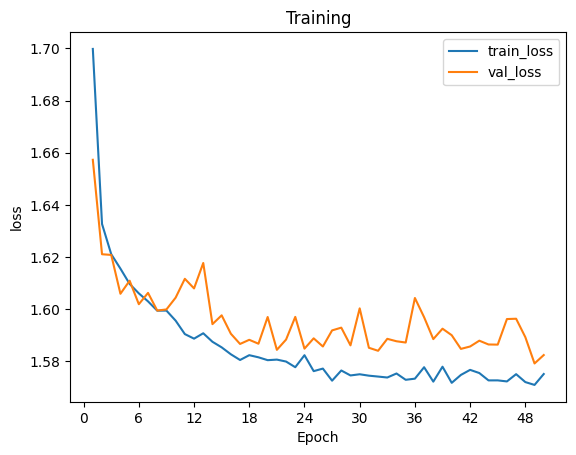

In [11]:
mlp = FashionMLP(hidden_dims=(512, 512)) 
history = mlp.train(train_loader, val_loader, 50)
plot_training(history)

Prediction: Bag, Truth: Bag


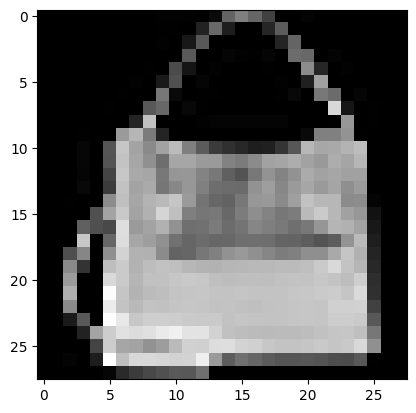

In [42]:
# Predict random observation from validation set
idx = torch.randint(0, len(val_loader), (1, ))
X, y = val_loader.dataset[idx]
pred = mlp.predict(X)[0].item()
print(f"Prediction: {class_names[pred]}, Truth: {class_names[y]}")
plt.imshow(torch.squeeze(X, dim=0), cmap="gray");

# Convolutional Neural Network

In [13]:
# TODO

# Vision Transformer

In [14]:
# TODO

# Summary

In [15]:
# TODO